## Video 5.3

In [1]:
import gensim,pickle
from gensim.parsing.preprocessing import preprocess_string
import json,glob
import collections
import matplotlib.pyplot as plt
import numpy as np
from utils import plotTopicProjections
# Convenience function to visualise terms in topics
%matplotlib inline

### Define path to news data

In [2]:
pathToData='/home/alex/packt_nlp/topics/en/'

### Test gensim in-built text pre-processing

In [3]:
preprocess_string('What is the point of learning NLP, do you think?')

['point', 'learn', 'nlp', 'think']

## Define Text Generator

In [4]:
class textGen():
    '''
    Object to iterate over text out of memory
    Generator: Yields tokenized documents one at a time
    @n is number of lines to read, -1 means all lines
    @start is line number to start from
    (useful for defining a holdout)
    '''
    def __init__(self,n=-1,start=0):
        print('Initialising textgenerator...')
        self.n=n
        self.start=start

    def __iter__(self):   
        for nFile,file in enumerate(glob.glob(pathToData+'news*json')):
            #print(nFile,self.n)
            if self.n>-1 and nFile>self.n:
                break
                    
            with open(file,'r') as inFile:
                for line in inFile:
                    
                    
                    if len(line)>0 and nFile>=self.start:
                        d=json.loads(line)
                        yield preprocess_string(d['text'])

## Define a test set to hold out to evaluate our topic models

In [5]:
holdout=450000
# Train on 450k out of ~500k

### Create dictionary by looping over tokens in all documents to build vocabulary

In [ ]:
%time dictionary = gensim.corpora.Dictionary(textGen(n=holdout))
# Define dictionary based on training data only

In [24]:
dictionary.filter_extremes()
# Drop terms that appear less than 5 times and more than 50% of documents
# Then filter to top 100k terms

In [25]:
with open('dict.pkl','wb') as outFile:
    pickle.dump(dictionary,outFile)
# Write out dictionary

In [7]:
with open('dict.pkl','rb') as inFile:
    dictionary=pickle.load(inFile)
# Read back in

## Define Corpus Object

In [8]:
class newsCorpus():
    '''
    Class wrapper for reading news data
    Generator: Yields indexed documents one at a time
    @n is number of lines to read, -1 means all lines
    @start is line number to start returning data
    (for creating holdout set)
    '''
    def __init__(self,n=-1,start=0):
        print('Initialising corpus...')
        self.n=n
        self.start=start
        
    def __iter__(self):   
        for nFile,file in enumerate(glob.glob(pathToData+'news*json')):
            #print(nFile,self.n)
            if self.n>-1 and nFile>self.n:
                break

            with open(file,'r') as inFile:
                for line in inFile:

                    if len(line)>0 and nFile>=self.start:
                        d=json.loads(line)
                        tokens=preprocess_string(d['text'])
                        yield dictionary.doc2bow(tokens)

## LDA

### Compare regular and multicore run times

In [46]:
%time resLda = gensim.models.ldamodel.LdaModel(newsCorpus(n=10000),\
                            num_topics=4,id2word=dictionary)
# Time test of single core implementation
# 2m.48

Initialising corpus...
CPU times: user 19 s, sys: 612 ms, total: 19.6 s
Wall time: 19.5 s


In [53]:
%time resLda = gensim.models.ldamulticore.LdaMulticore(\
            newsCorpus(n=10000),num_topics=4,id2word=dictionary)
# Time test of multi-core implementation
# 1m.53

Initialising corpus...
CPU times: user 12min 2s, sys: 7.13 s, total: 12min 9s
Wall time: 11min 53s


## Train an LDA on test set with 4 topics

In [ ]:
%time resLda = gensim.models.ldamulticore.LdaMulticore(\
            newsCorpus(n=holdout),num_topics=4,id2word=dictionary)

## Train an LDA on test set with 4 topics

In [34]:
%time resLda10 = gensim.models.ldamulticore.LdaMulticore(\
        newsCorpus(n=holdout),num_topics=10,id2word=dictionary)

Initialising corpus...
CPU times: user 55min 14s, sys: 32.7 s, total: 55min 47s
Wall time: 53min 54s


In [38]:
with open('lda10.pkl','wb') as outFile:
    pickle.dump(resLda10,outFile)

In [ ]:
with open('lda10.pkl','rb') as inFile:
    resLda10=pickle.load(inFile)

In [28]:
with open('lda.pkl','wb') as outFile:
    pickle.dump(resLda,outFile)

In [10]:
with open('lda.pkl','rb') as inFile:
    resLda=pickle.load(inFile)

## Visualise 4-topic and 10-topic models

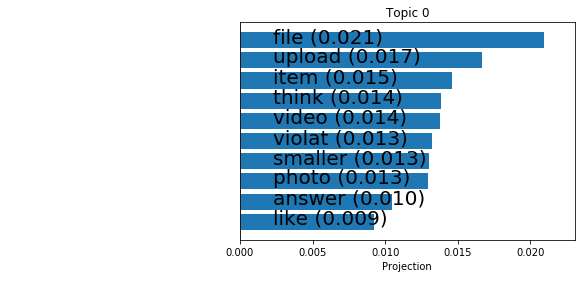

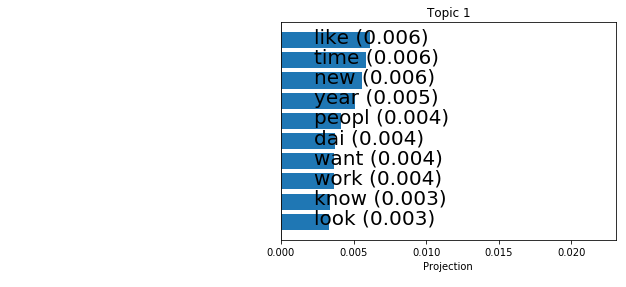

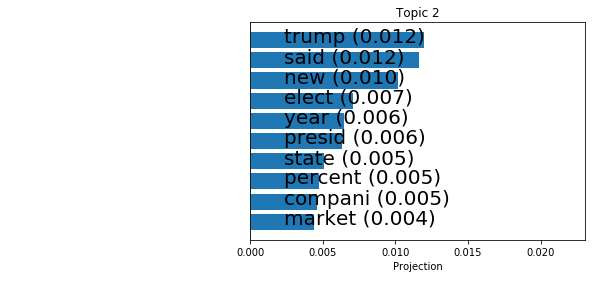

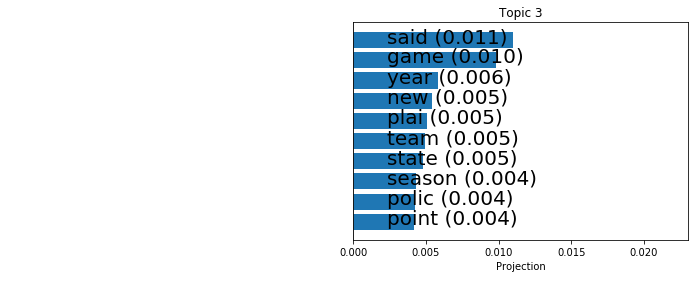

In [12]:
plotTopicProjections(resLda,dictionary,scale=True,nTerms=10)

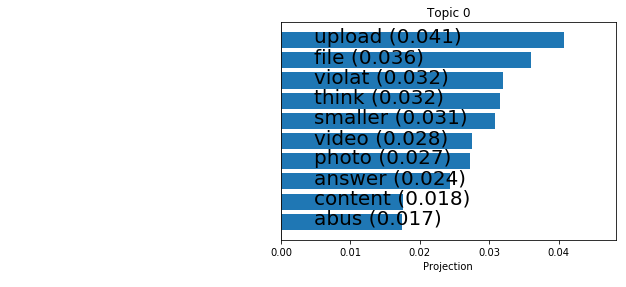

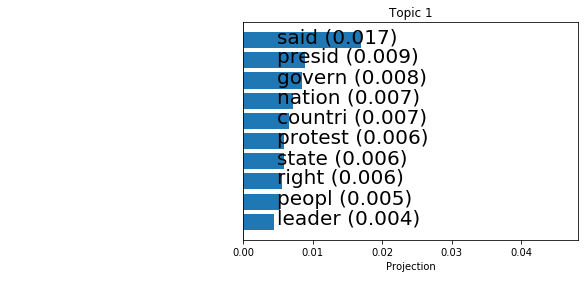

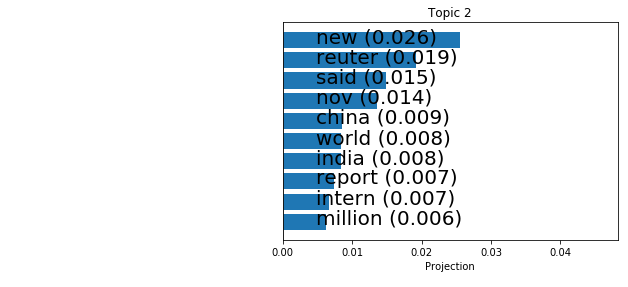

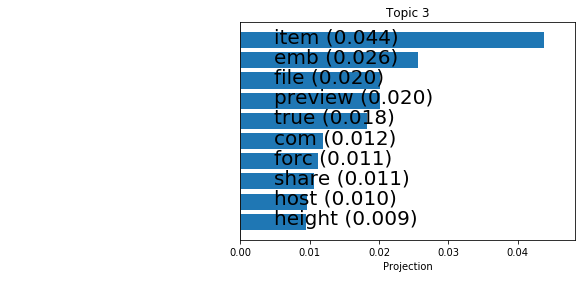

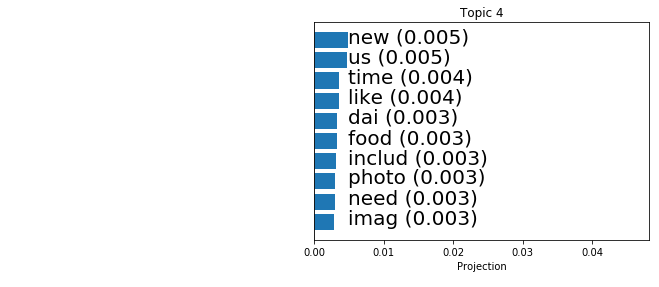

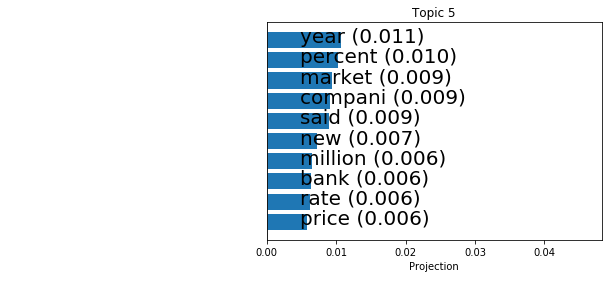

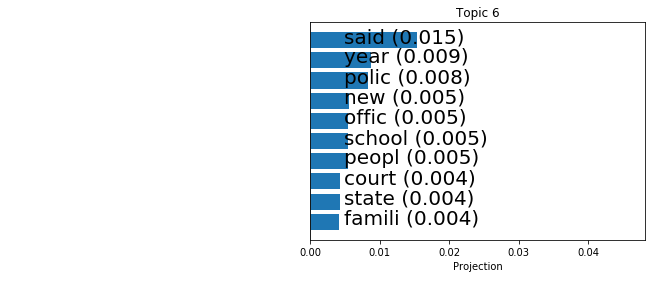

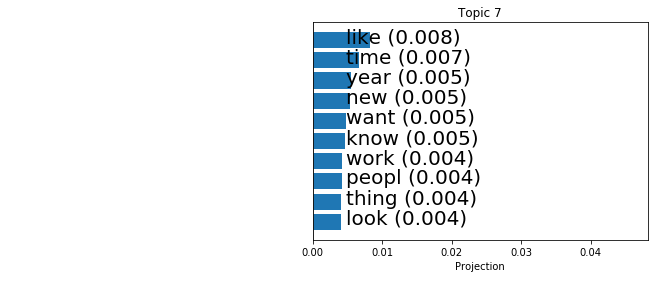

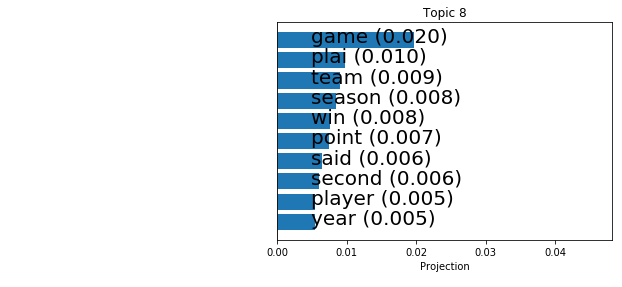

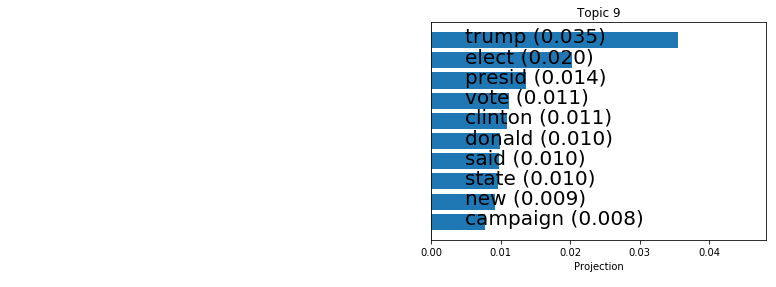

In [43]:
plotTopicProjections(resLda10,dictionary,scale=True,nTerms=10)

### Each document has a projection on each topic

In [13]:
resLda.get_document_topics(dictionary.doc2bow(\
            preprocess_string('I love this great video! Take a look')))

[(0, 0.16069222570804087),
 (1, 0.73776222862530261),
 (2, 0.050514666215704461),
 (3, 0.051030879450952235)]

### TFIDF

### Calculate TFIDF scaling from dictionary

In [56]:
tfidf = gensim.models.TfidfModel(dictionary=dictionary)

CPU times: user 77.4 ms, sys: 0 ns, total: 77.4 ms
Wall time: 78 ms


In [30]:
with open('tfidf.pkl','wb') as outFile:
    pickle.dump(tfidf,outFile)

In [17]:
with open('tfidf.pkl','rb') as inFile:
    tfidf=pickle.load(inFile)

## Train an LDA using TFIDF scaled corpus (4 topics)

In [32]:
%time res_tfidf = gensim.models.ldamulticore.LdaMulticore(\
    tfidf[newsCorpus(n=holdout)],num_topics=4,id2word=dictionary)

Initialising corpus...
CPU times: user 53min 43s, sys: 28.4 s, total: 54min 11s
Wall time: 52min 33s


In [34]:
with open('tfidf_lda.pkl','wb') as outFile:
    pickle.dump(res_tfidf,outFile)

In [18]:
with open('tfidf_lda.pkl','rb') as inFile:
    res_tfidf=pickle.load(inFile)

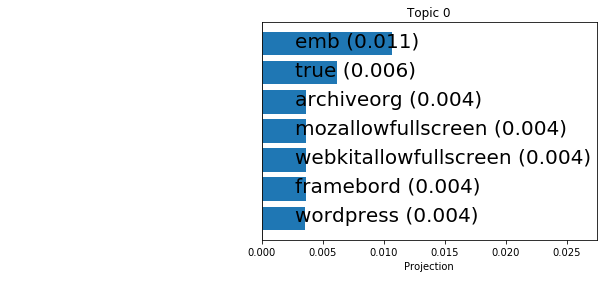

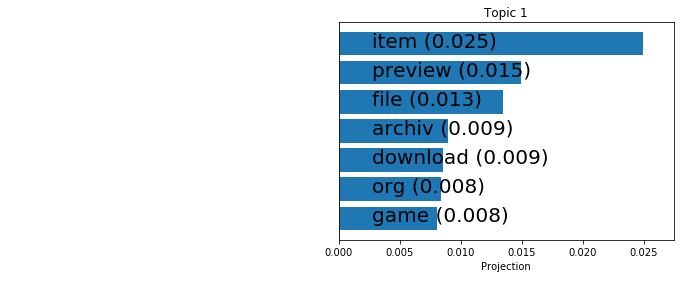

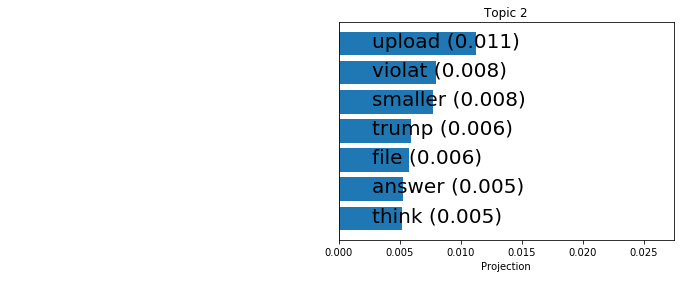

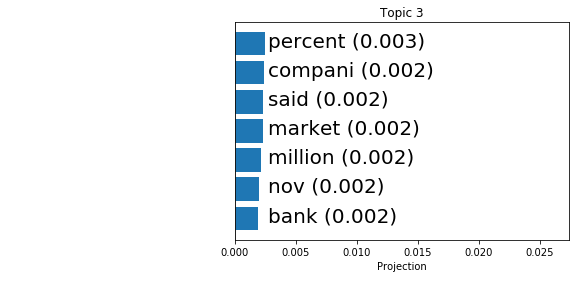

In [22]:
plotTopicProjections(res_tfidf,dictionary,scale=True,nTerms=7)

## Train an LDA using TFIDF scaled corpus (4 topics)

In [41]:
%time res_tfidf_10 = gensim.models.ldamulticore.LdaMulticore(\
    tfidf[newsCorpus(n=holdout)],num_topics=10,id2word=dictionary)

Initialising corpus...
CPU times: user 54min 30s, sys: 29.8 s, total: 55min
Wall time: 53min 22s


In [48]:
with open('tfidf_lda_10.pkl','wb') as outFile:
    pickle.dump(res_tfidf_10,outFile)

In [49]:
with open('tfidf_lda_10.pkl','rb') as inFile:
    res_tfidf_10=pickle.load(inFile)

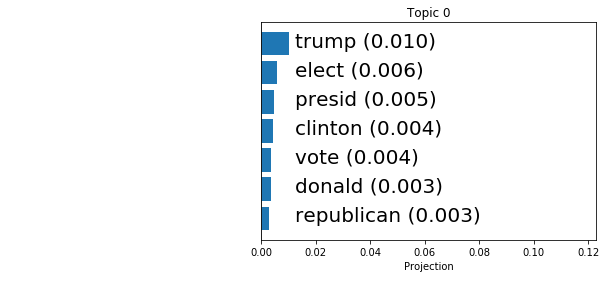

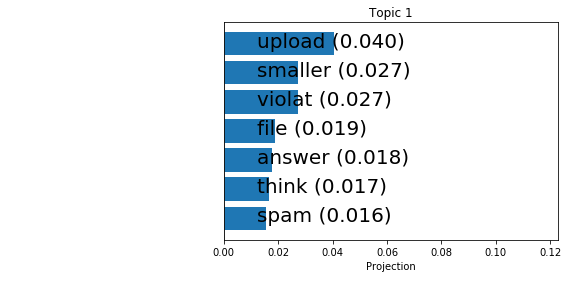

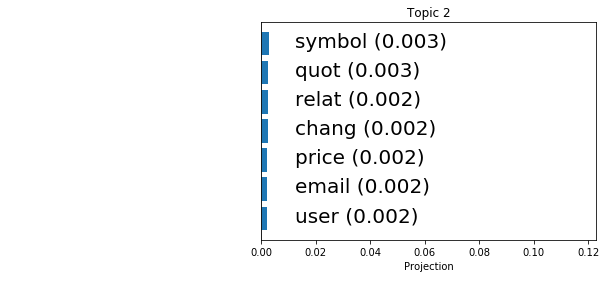

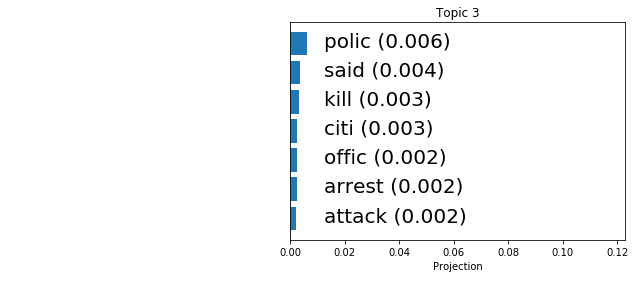

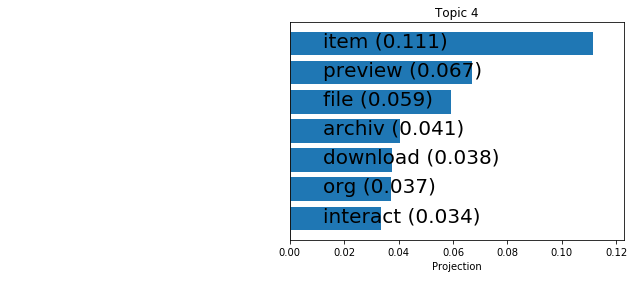

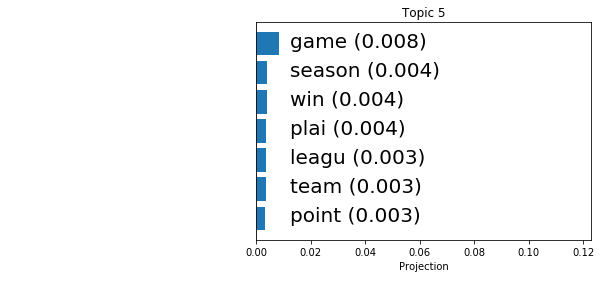

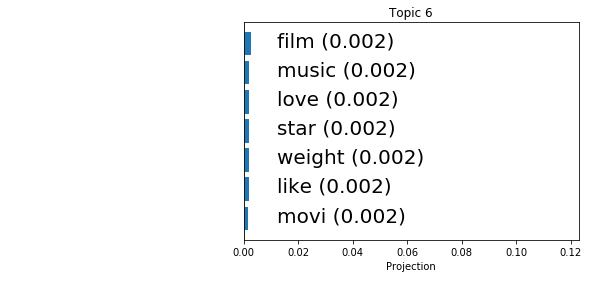

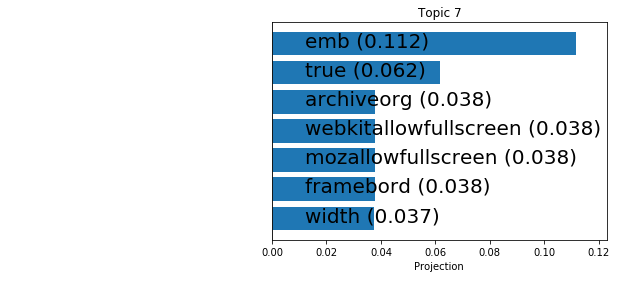

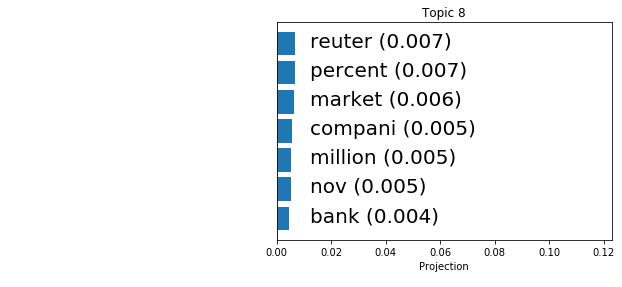

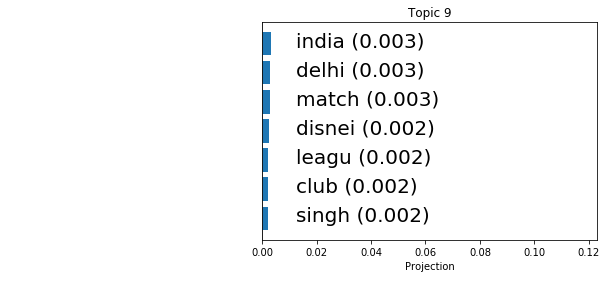

In [50]:
plotTopicProjections(res_tfidf_10,dictionary,scale=True,nTerms=7)

## Train an LSI Model (4 topics)

In [39]:
%time resLsi = gensim.models.lsimodel.LsiModel(newsCorpus(n=holdout)\
                            ,num_topics=4,id2word=dictionary)

Initialising corpus...
CPU times: user 24min 30s, sys: 20.7 s, total: 24min 51s
Wall time: 23min 53s


In [40]:
with open('lsi.pkl','wb') as outFile:
    pickle.dump(resLsi,outFile)

In [24]:
with open('lsi.pkl','rb') as inFile:
    resLsi=pickle.load(inFile)

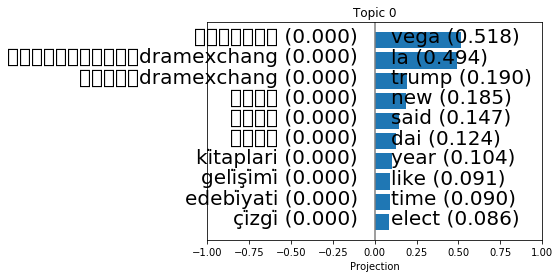

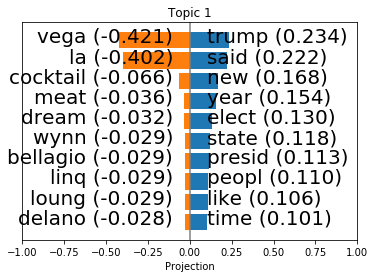

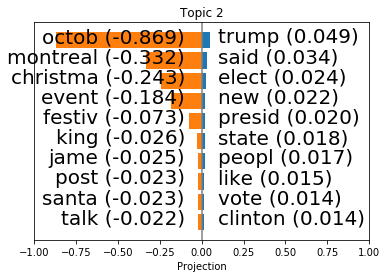

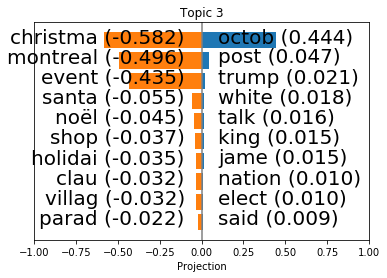

In [51]:
plotTopicProjections(resLsi,dictionary,plotNegative=True,nTerms=10)

### TFIDF Transformation

In [43]:
%time resLsiTfidf = gensim.models.lsimodel.LsiModel(\
            tfidf_corpus[newsCorpus(n=holdout)],num_topics=4,id2word=dictionary)

Initialising corpus...
CPU times: user 26min 53s, sys: 22.5 s, total: 27min 16s
Wall time: 26min 17s


In [46]:
with open('lsi_tfidf.pkl','wb') as outFile:
    pickle.dump(resLsiTfidf,outFile)

In [27]:
with open('lsi_tfidf.pkl','rb') as inFile:
    resLsiTfidf=pickle.load(inFile)

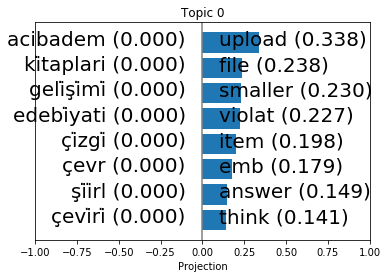

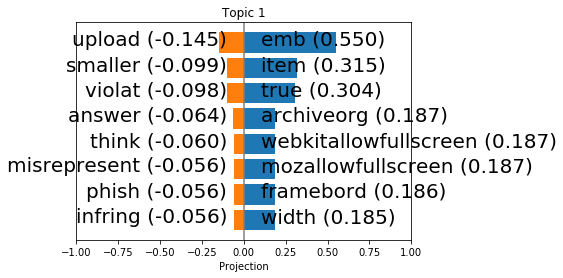

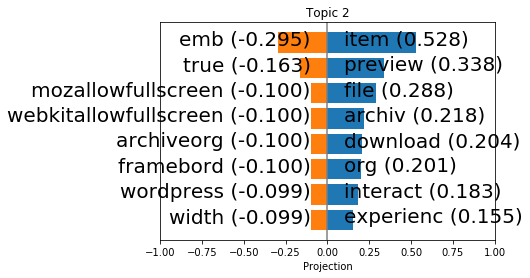

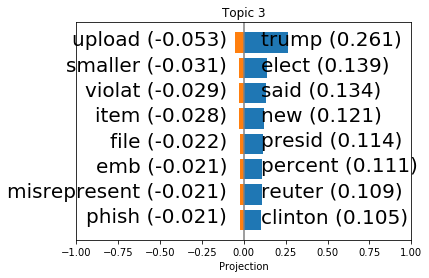

In [53]:
plotTopicProjections(resLsiTfidf,dictionary,plotNegative=True,nTerms=8)

## Plot topic projections of holdout data

In [69]:
def plotProjections(model,corpus):
    '''
    Covenience function to visualise the dominant topic
    matches over a corpus
    '''
    maxProjections=list(map(lambda c: max([p[1] for p in \
                    model.get_document_topics(c)]),corpus))
    plt.hist(maxProjections,bins=np.linspace(0,1,10))
    plt.axvline(np.mean(maxProjections),linestyle='--',color='grey')

Initialising corpus...


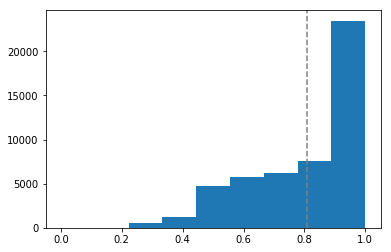

In [70]:
plotProjections(resLda,newsCorpus(start=holdout))

Initialising corpus...


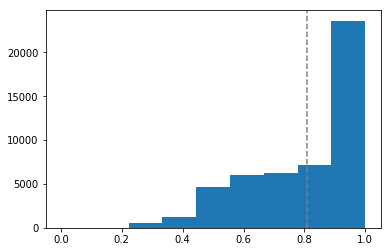

In [71]:
plotProjections(res_tfidf,newsCorpus(start=holdout))

## Assess Topic Models on Holdout Data

In [31]:
perpLda=resLda.bound(newsCorpus(start=holdout))

Initialising corpus...


In [32]:
perpTfidf=res_tfidf.bound(tfidf[newsCorpus(start=holdout)])

Initialising corpus...


In [54]:
print('LDA perplexity = {:}'.format(int(perpLda/1000)))

LDA perplexity = -83890


In [55]:
print('LDA TFIDF perplexity = {:}'.format(int(perpTfidf/1000)))

LDA TFIDF perplexity = -3702


TFIDF scaling increases perplexity i.e. improves model